In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter, writer
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math


D:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_cluster_label(datasets, datafile):
    with open('./retrieve_time_running_record/{}_time.pkl'.format(datasets), "rb") as fp:
        time = pickle.load(fp)
    df = pd.read_csv(datafile)
    ts = []
    dataset = []
    SSE = []
    label_preds = []
    df_group = df.groupby(['target_event_id'], sort=False)
    for target_event_id, frame in df_group:
        if frame['rn'].iloc[0] != 1:
            continue
        ts.append(pd.to_datetime(time[target_event_id]))
    for _ in range(len(ts)):
        ts[_] = (3600*ts[_].hour + 60*ts[_].minute + ts[_].second)*2*math.pi/3600/24
        dataset.append([math.cos(ts[_]), math.sin(ts[_])])
    for num_of_clusters in range(1, 25):
        dataset = np.array(dataset)
        estimator = KMeans(num_of_clusters)  # 构造聚类器
        estimator.fit(dataset)  # 聚类
        label_pred = estimator.labels_  # 获取聚类标签
        centroids = estimator.cluster_centers_  # 获取聚类中心
        inertia = estimator.inertia_
        label_preds.append(label_pred)
        SSE.append(inertia)
    cmpSSE = []
    for _ in range(22):
        cmpSSE.append((SSE[_] - SSE[_ + 1]) / (SSE[_ + 1] - SSE[_ + 2]))
    for _ in range(22):
        if cmpSSE[_] < cmpSSE[_ + 1]:
            num_of_clusters = _ + 2
            break
    print("num_of_clusters:", num_of_clusters)
    return label_preds[num_of_clusters-1]

In [34]:
def generate_representation(model, dataset, input_label_list):
    loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    label_list = []
    rep_list = []
    model.eval()
    with torch.no_grad():
        with tqdm(enumerate(loader), desc="loading representation...") as loop:
            for i, batch in loop:
                inputs, labels, lengths = batch
                rep, _ = model(inputs, lengths)
                for _ in rep:
                    rep_list.append(_)
                label_list.append(labels.cpu().numpy())

    reps = torch.stack(rep_list, axis=0).squeeze()
    # labels = np.array(label_list)

    hour_indicator = np.array(input_label_list)

    hour_list = np.unique(hour_indicator)
    hour_rep_list = []
    for lab in hour_list:
        indices = np.where(hour_indicator == lab)[0]
        hour_rep_list.append(reps[indices])
    return hour_list, hour_rep_list

In [52]:
from Model import LSTMClassifier
from Dataset import EncodedDataset
def collate_fn(batch):
    inputs, labels, lengths = zip(*batch)
    inputs_pad = pad_sequence([torch.from_numpy(x) for x in inputs], padding_value=0)
    return inputs_pad.float().to(device), torch.LongTensor(labels).to(device), torch.LongTensor(lengths).to(device)

with open('LZD_train_2020-01(finetune).pkl', "rb") as fp:
    train_dataset = pickle.load(fp)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_dataset[0][0].shape[1]
hidden_size=300
layer_num=2
model = LSTMClassifier(input_size, hidden_size, layer_num).to(device)
src_label_list = generate_cluster_label('LZD', 'E:\Transfer_Learning\Data\LZD\csv/train_2020-01.csv')
checkpoint = torch.load('HK_2020-01_sub_by_hour_new.pt')
model.load_state_dict(checkpoint['model'])
tgt_hour_list, tgt_hour_rep_list = generate_representation(model, train_dataset, src_label_list)

num_of_clusters: 4


loading representation...: 6012it [00:37, 162.02it/s]


D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:805: 

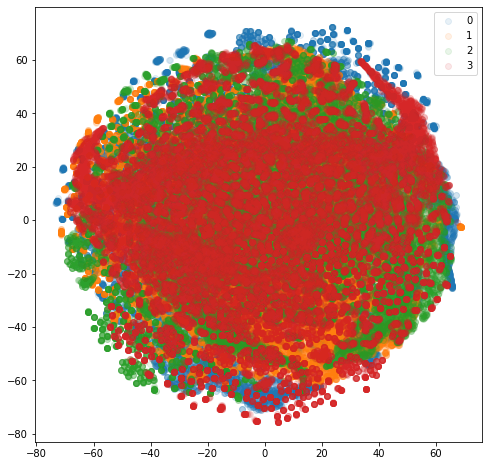

In [60]:
from sklearn.manifold import TSNE 
 
tsne = TSNE(n_components=2) 
X_tsne0 = tsne.fit_transform(tgt_hour_rep_list[0].cpu().numpy()) 
X_tsne1 = tsne.fit_transform(tgt_hour_rep_list[1].cpu().numpy()) 
X_tsne2 = tsne.fit_transform(tgt_hour_rep_list[2].cpu().numpy()) 
X_tsne3 = tsne.fit_transform(tgt_hour_rep_list[3].cpu().numpy()) 
plt.figure(figsize=(8, 8)) 
plt.scatter(X_tsne0[:,0], X_tsne0[:,1], alpha=0.1, label='0')
plt.scatter(X_tsne1[:,0], X_tsne1[:,1], alpha=0.1, label='1')
plt.scatter(X_tsne2[:,0], X_tsne2[:,1], alpha=0.1, label='2')
plt.scatter(X_tsne3[:,0], X_tsne3[:,1], alpha=0.1, label='3')
plt.legend()
plt.show()

loading representation...: 6012it [00:49, 121.27it/s]
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


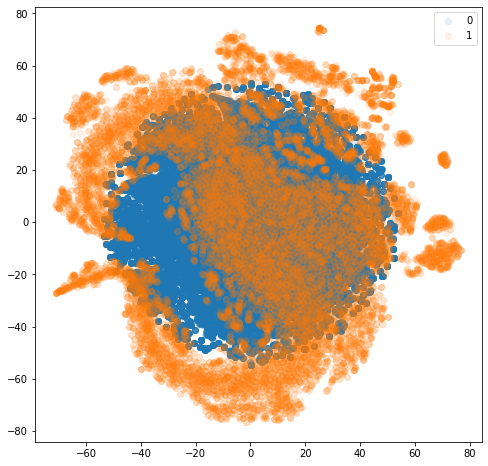

In [63]:
def generate_representation(model, dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    label_list = []
    rep_list = []
    model.eval()
    with torch.no_grad():
        with tqdm(enumerate(loader), desc="loading representation...") as loop:
            for i, batch in loop:
                inputs, labels, lengths = batch
                rep, _ = model(inputs, lengths)
                for _ in rep:
                    rep_list.append(_)
                for _ in labels:
                    label_list.append(_.cpu().numpy())

    reps = torch.stack(rep_list, axis=0).squeeze()
    labels = np.array(label_list)
    hour_rep_list = []
    for lab in [0,1]:
        indices = np.where(labels == lab)[0]
        hour_rep_list.append(reps[indices])
    return hour_rep_list
from Model import LSTMClassifier
from Dataset import EncodedDataset
def collate_fn(batch):
    inputs, labels, lengths = zip(*batch)
    inputs_pad = pad_sequence([torch.from_numpy(x) for x in inputs], padding_value=0)
    return inputs_pad.float().to(device), torch.LongTensor(labels).to(device), torch.LongTensor(lengths).to(device)

with open('LZD_train_2020-01(finetune).pkl', "rb") as fp:
    train_dataset = pickle.load(fp)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_dataset[0][0].shape[1]
hidden_size=300
layer_num=2
model = LSTMClassifier(input_size, hidden_size, layer_num).to(device)
checkpoint = torch.load('HK_2020-01_sub_by_hour_new.pt')
model.load_state_dict(checkpoint['model'])
tgt_hour_rep_list = generate_representation(model, train_dataset)
from sklearn.manifold import TSNE 
 
tsne = TSNE(n_components=2) 
X_tsne0 = tsne.fit_transform(tgt_hour_rep_list[0].cpu().numpy()) 
X_tsne1 = tsne.fit_transform(tgt_hour_rep_list[1].cpu().numpy()) 

plt.figure(figsize=(8, 8)) 
plt.scatter(X_tsne0[:,0], X_tsne0[:,1], alpha=0.1, label='0')
plt.scatter(X_tsne1[:,0], X_tsne1[:,1], alpha=0.1, label='1')

plt.legend()
plt.show()

In [3]:
def load_source_domain_representation(src_label_list, src_model_name):
    """
    return src_rep
    """
    with open(src_model_name.replace(".pt", "_rep.pkl"), "rb") as fp:
        data = pickle.load(fp)
        labels = np.array(data["label"])
        reps = data["rep"]
    hour_indicator = np.array(src_label_list)

    hour_list = np.unique(hour_indicator)
    hour_rep_list = []
    for lab in hour_list:
        indices = np.where(hour_indicator == lab)[0]
        hour_rep_list.append(reps[indices])

    return hour_list, hour_rep_list

In [38]:
def load_source_domain_representation(src_model_name):
    """
    return src_rep
    """
    with open(src_model_name.replace(".pt", "_rep.pkl"), "rb") as fp:
        data = pickle.load(fp)
        labels = np.array(data["label"])
        reps = data["rep"]
    
    hour_rep_list = []
    for lab in [0, 1]:
        indices = np.where(labels == lab)[0]
        hour_rep_list.append(reps[indices])

    return hour_rep_list

In [39]:
src_label_list = generate_cluster_label('LZD', 'E:\Transfer_Learning\Data\LZD\csv/train_2020-01.csv')
src_hour_list, src_hour_rep_list = load_source_domain_representation('LZD_2020-01_finetune.pt')

num_of_clusters: 4


In [ ]:
from sklearn.manifold import TSNE 
 
tsne = TSNE(n_components=2) 
X_tsne0 = tsne.fit_transform(src_hour_rep_list[0]) 
X_tsne1 = tsne.fit_transform(src_hour_rep_list[1]) 
X_tsne2 = tsne.fit_transform(src_hour_rep_list[2]) 
X_tsne3 = tsne.fit_transform(src_hour_rep_list[3]) 

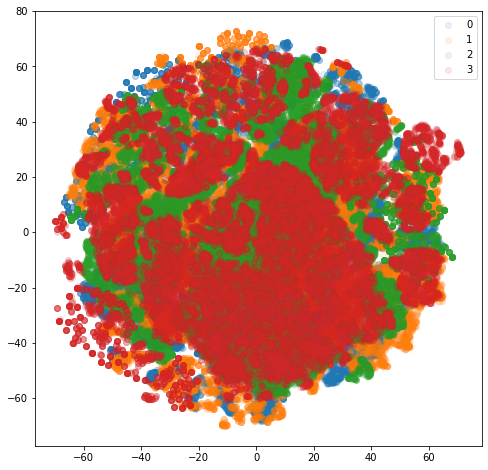

In [35]:
plt.figure(figsize=(8, 8)) 
plt.scatter(X_tsne0[:,0], X_tsne0[:,1], alpha=0.1, label='0')
plt.scatter(X_tsne1[:,0], X_tsne1[:,1], alpha=0.1, label='1')
plt.scatter(X_tsne2[:,0], X_tsne2[:,1], alpha=0.1, label='2')
plt.scatter(X_tsne3[:,0], X_tsne3[:,1], alpha=0.1, label='3')
plt.legend()
plt.show()